# Assignment 3

* Gender: Gender of the individual

* Age: Age of the individual

* Height: Height of the individual

* Weight: Weight of the individual

* family_history_with_overweight: Whether the individual has a family member suffered or suffers from overweight

* FAVC: Frequency of consuming high-calorie foods

* FCVC: Frequency of of consuming vegetables

* NCP: Number of main meals per day

* CAEC: Frequency of eating any food between meals

* SMOKE: Whether the individual smoke

* CH2O: Amount of water consumed daily

* SCC: Whether the individual monitors their daily calories

* FAF: Frequency of having physical activity

* TUE: Time using technological devices (cell phone, videogames, television, computer and others)

* CALC: Frequency of consuming alcohol

* MTRANS: Mode of transportation used by the individual (e.g., walking, biking, public transportation, etc.).

* NObeyesdad: Obesity level

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical


SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Load, preprocess, split data

Load the dataset, preprocess the data (min max norm for numberical, one hot for categorical), and split to train and test sets

In [2]:
df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")

In [3]:

# One-hot encode the categorical features
df_encoded = pd.get_dummies(df, columns=[
    'Gender', 
    'family_history_with_overweight', 
    'FAVC', 
    'CAEC', 
    'SMOKE', 
    'SCC', 
    'CALC', 
    'MTRANS', 
    'NObeyesdad'
])

# List of numerical features
numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

# Initialize the StandardScaler
scaler = MinMaxScaler()

# Apply the scaler to the numerical features
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])

# Display the first few rows of the scaled dataframe
df_encoded
df_encoded.columns

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'Gender_Female', 'Gender_Male', 'family_history_with_overweight_no',
       'family_history_with_overweight_yes', 'FAVC_no', 'FAVC_yes',
       'CAEC_Always', 'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no',
       'SMOKE_no', 'SMOKE_yes', 'SCC_no', 'SCC_yes', 'CALC_Always',
       'CALC_Frequently', 'CALC_Sometimes', 'CALC_no', 'MTRANS_Automobile',
       'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation',
       'MTRANS_Walking', 'NObeyesdad_Insufficient_Weight',
       'NObeyesdad_Normal_Weight', 'NObeyesdad_Obesity_Type_I',
       'NObeyesdad_Obesity_Type_II', 'NObeyesdad_Obesity_Type_III',
       'NObeyesdad_Overweight_Level_I', 'NObeyesdad_Overweight_Level_II'],
      dtype='object')

In [4]:
X = df_encoded.drop(['NObeyesdad_Insufficient_Weight',
       'NObeyesdad_Normal_Weight', 'NObeyesdad_Obesity_Type_I',
       'NObeyesdad_Obesity_Type_II', 'NObeyesdad_Obesity_Type_III',
       'NObeyesdad_Overweight_Level_I', 'NObeyesdad_Overweight_Level_II'], axis=1)
y = df_encoded[['NObeyesdad_Insufficient_Weight',
       'NObeyesdad_Normal_Weight', 'NObeyesdad_Obesity_Type_I',
       'NObeyesdad_Obesity_Type_II', 'NObeyesdad_Obesity_Type_III',
       'NObeyesdad_Overweight_Level_I', 'NObeyesdad_Overweight_Level_II']]

In [36]:
df.head().to_csv("small.csv", index=False)

In [6]:
X.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,Gender_Male,...,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0.148936,0.320755,0.186567,0.5,0.666667,0.5,0.000000,0.5,1,0,...,0,0,0,0,1,0,0,0,1,0
1,0.148936,0.132075,0.126866,1.0,0.666667,1.0,1.000000,0.0,1,0,...,1,0,0,1,0,0,0,0,1,0
2,0.191489,0.660377,0.283582,0.5,0.666667,0.5,0.666667,0.5,0,1,...,0,0,1,0,0,0,0,0,1,0
3,0.276596,0.660377,0.358209,1.0,0.666667,0.5,0.666667,0.0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,0.170213,0.622642,0.379104,0.5,0.000000,0.5,0.000000,0.0,0,1,...,0,0,0,1,0,0,0,0,1,0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.3, random_state=SEED)

## Obeysety Distribution

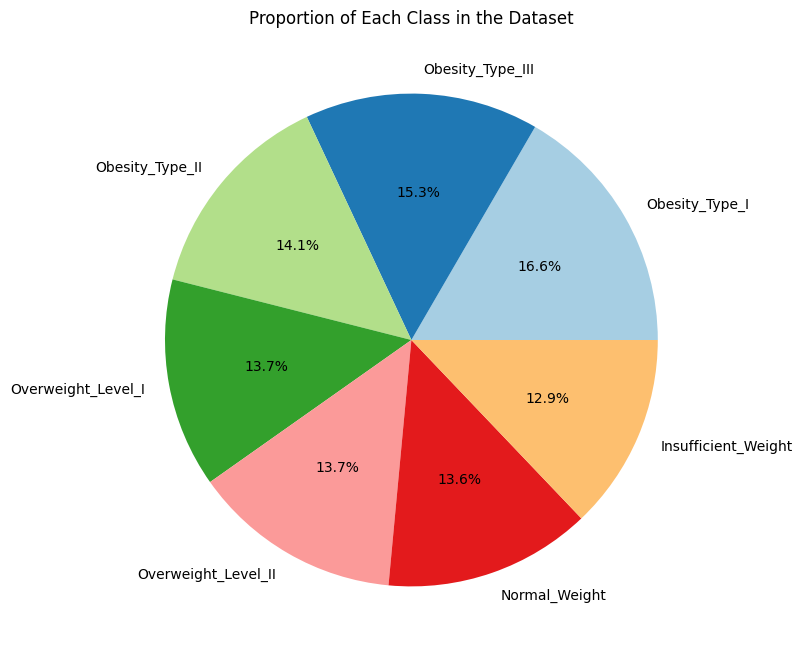

In [8]:
class_proportion = df['NObeyesdad'].value_counts(normalize=True) * 100

# print(class_proportion)
plt.figure(figsize=(10, 8))
class_proportion.plot(kind='pie', autopct='%1.1f%%', 
                      colors=plt.cm.Paired.colors, 
                      )
plt.title('Proportion of Each Class in the Dataset')
plt.ylabel('')
plt.show()

## Method 1

### Logistic Regression

The coefficients of the logistic regression model indicate the importance and influence of each feature on the obesity levels.

This helps identify which factors are significant predictors of obesity.

In [9]:
param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs'],
    'max_iter': [1000]
}

# Initialize the logistic regression model
log_reg = LogisticRegression(random_state=SEED)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train.argmax(axis=1))

best_params = grid_search.best_params_

best_logistic = LogisticRegression(max_iter=1000, random_state=SEED,
                                   C=best_params['C'],
                                   penalty=best_params['penalty'],
                                   solver=best_params['solver'])


best_logistic.fit(X_train, y_train.argmax(axis=1))

y_pred_log = best_logistic.predict(X_test)

print("\nLogistic Regression\n")
print("Accuracy:", accuracy_score(y_test.argmax(axis=1), y_pred_log))
print("Classification Report:\n", classification_report(y_test.argmax(axis=1), y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test.argmax(axis=1), y_pred_log))

Fitting 5 folds for each of 6 candidates, totalling 30 fits

Logistic Regression

Accuracy: 0.9022082018927445
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94        86
           1       0.88      0.80      0.84        93
           2       0.95      0.91      0.93       102
           3       0.94      0.99      0.96        88
           4       0.98      0.99      0.98        98
           5       0.83      0.77      0.80        88
           6       0.82      0.86      0.84        79

    accuracy                           0.90       634
   macro avg       0.90      0.90      0.90       634
weighted avg       0.90      0.90      0.90       634

Confusion Matrix:
 [[85  1  0  0  0  0  0]
 [10 74  0  0  0  7  2]
 [ 0  0 93  5  2  0  2]
 [ 0  0  1 87  0  0  0]
 [ 0  0  0  1 97  0  0]
 [ 0  9  0  0  0 68 11]
 [ 0  0  4  0  0  7 68]]


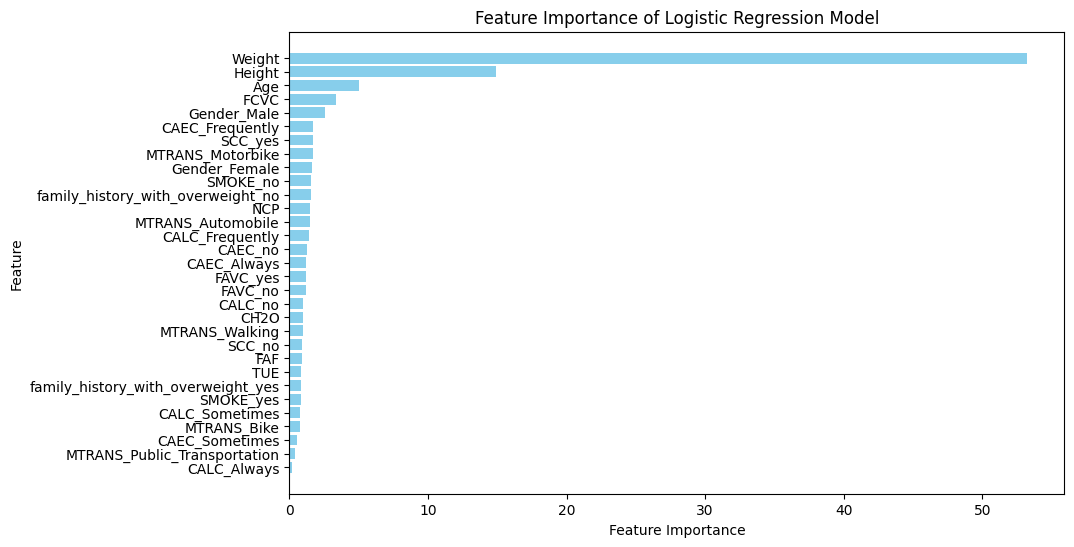

In [10]:

total_coefficients = np.sum(np.abs(best_logistic.coef_), axis=0)/7
sorted_indices = np.argsort(total_coefficients)
sorted_coefficients = total_coefficients[sorted_indices]
sorted_feature_names = X.columns[sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_coefficients, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of Logistic Regression Model')
# plt.text(30, 0.25, """NCP: Number of Meals\n
#                  FAVC: High """, fontsize=12,
#          bbox=dict(facecolor='white', alpha=0.5))

plt.show()

## Random Forest Classifier

In [11]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

rf_clf = RandomForestClassifier(random_state=SEED)

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train.argmax(axis=1))


Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [12]:

print("Random Forest Classifier\n")
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

y_pred_rf = grid_search.predict(X_test)

print("Accuracy:\n",accuracy_score(y_test.argmax(axis=1), y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test.argmax(axis=1), y_pred_rf))
# Confusion Matrix gives an error
print("\nConfusion Matrix:\n",confusion_matrix(y_test.argmax(axis=1), y_pred_rf))


Random Forest Classifier

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.9431218506642235
Accuracy:
 0.9258675078864353

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94        86
           1       0.77      0.90      0.83        93
           2       0.99      0.92      0.95       102
           3       0.97      0.99      0.98        88
           4       1.00      0.99      0.99        98
           5       0.91      0.82      0.86        88
           6       0.94      0.91      0.92        79

    accuracy                           0.93       634
   macro avg       0.93      0.92      0.93       634
weighted avg       0.93      0.93      0.93       634


Confusion Matrix:
 [[81  5  0  0  0  0  0]
 [ 6 84  0  0  0  2  1]
 [ 0  3 94  3  0  1  1]
 [ 0  0  1 87  0  0  0]
 [ 0  1  0  0 97  0  0]
 [ 0 13  0  0  0 72  3]
 [ 0  3  0  0  0  4 72


Feature Importance:
                                     Importance
Weight                                0.280574
Age                                   0.092110
FCVC                                  0.084654
Height                                0.082842
NCP                                   0.052453
CH2O                                  0.047145
TUE                                   0.046845
FAF                                   0.045374
Gender_Male                           0.036221
Gender_Female                         0.030836
family_history_with_overweight_yes    0.021898
CALC_no                               0.020988
CALC_Sometimes                        0.020971
family_history_with_overweight_no     0.020541
CAEC_Sometimes                        0.018586
MTRANS_Public_Transportation          0.016296
CAEC_Frequently                       0.016247
MTRANS_Automobile                     0.014151
FAVC_yes                              0.011327
FAVC_no                               

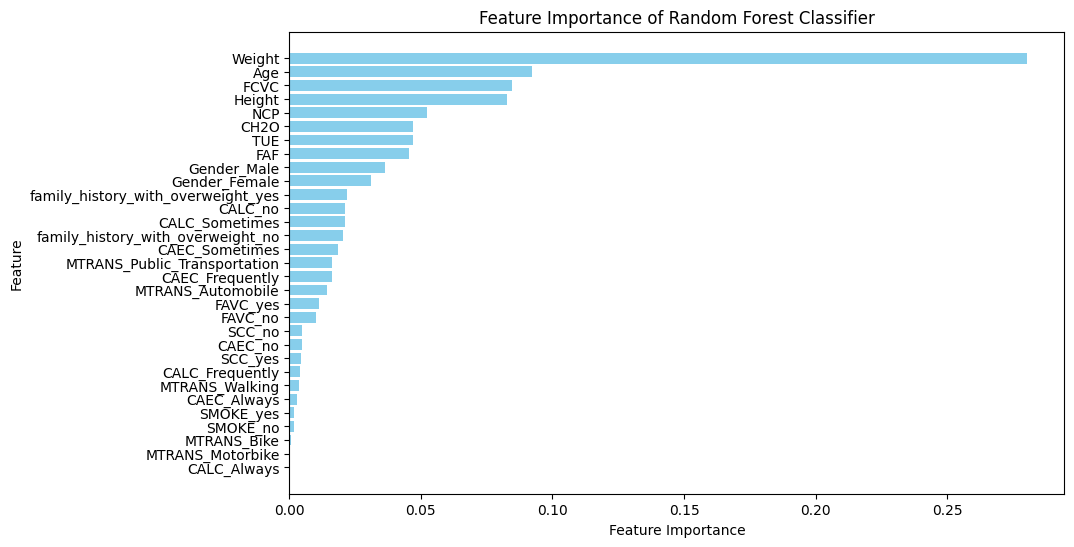

In [13]:

best_rf_clf = grid_search.best_estimator_
feature_importance = pd.DataFrame(best_rf_clf.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)
feature_importance_asc = feature_importance.sort_values('Importance', ascending=True)
print("\nFeature Importance:\n", feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_asc.index, feature_importance_asc['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of Random Forest Classifier')
plt.show()

## SVM

In [14]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf' kernel
}

svm_clf = SVC(random_state=SEED)

grid_search = GridSearchCV(estimator=svm_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train.argmax(axis=1))

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.9255084745762712



SVM Classifier

Accuracy: 0.919558359621451

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93        86
           1       0.89      0.80      0.84        93
           2       0.98      0.95      0.97       102
           3       0.96      1.00      0.98        88
           4       1.00      0.99      0.99        98
           5       0.85      0.83      0.84        88
           6       0.84      0.89      0.86        79

    accuracy                           0.92       634
   macro avg       0.92      0.92      0.92       634
weighted avg       0.92      0.92      0.92       634


Confusion Matrix:
 [[84  2  0  0  0  0  0]
 [10 74  0  0  0  6  3]
 [ 0  0 97  3  0  0  2]
 [ 0  0  0 88  0  0  0]
 [ 0  0  0  1 97  0  0]
 [ 0  7  0  0  0 73  8]
 [ 0  0  2  0  0  7 70]]


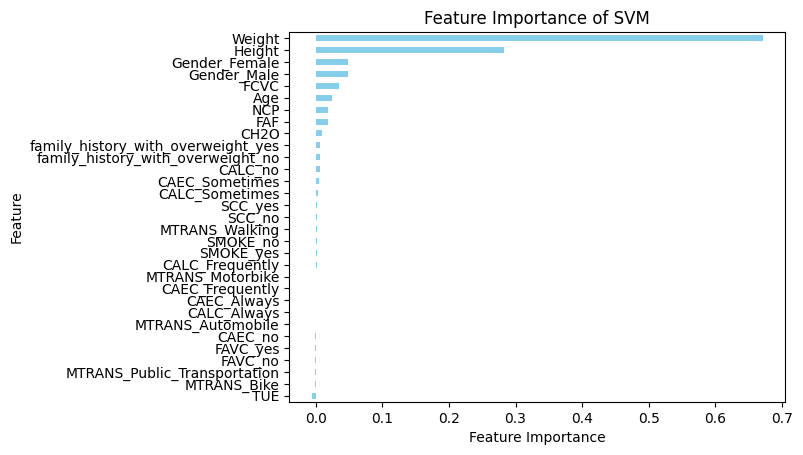

In [15]:

best_svm_clf = grid_search.best_estimator_
y_pred_svm = best_svm_clf.predict(X_test)

print("\nSVM Classifier\n")
print("Accuracy:", accuracy_score(y_test.argmax(axis=1), y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test.argmax(axis=1), y_pred_svm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test.argmax(axis=1), y_pred_svm))

result_svr = permutation_importance(best_svm_clf, X_test, y_test.argmax(axis=1), n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result_svr.importances_mean
feat_names = list(X.columns)

importance = pd.DataFrame(sorted_idx, index=feat_names, columns=['Importance'])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', title='Feature Importance of SVM', color='skyblue', legend=False)
plt.ylabel('Feature')
plt.xlabel('Feature Importance')
plt.show()

## Neural Network

In [ ]:
# from sklearn.preprocessing import LabelEncoder

# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)



model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(7, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# model.summary()

history = model.fit(X_train, y_train, epochs=100, batch_size=4, validation_split=0.2, verbose=2)

# model.save('obesity_model.h5')


### Custom permutation importance

In [33]:

y_pred_nn = model.predict(X_test)
y_pred_nn_classes = y_pred_nn.argmax(axis=1)

print("\nNeural Network\n")
print("\nAccuracy:", accuracy_score(y_test.argmax(axis=1), y_pred_nn_classes))
print("\nClassification Report:\n", classification_report(y_test.argmax(axis=1), y_pred_nn_classes))
print("\nConfusion Matrix:\n", confusion_matrix(y_test.argmax(axis=1), y_pred_nn_classes))

# weights = model.layers[0].get_weights()[0]

# feature_importance = abs(weights).sum(axis=1)

# feature_names = X.columns

# sorted_indices = feature_importance.argsort()[::-1]
# sorted_feature_importance = feature_importance[sorted_indices]
# sorted_feature_names = feature_names[sorted_indices]

# plt.figure(figsize=(10, 6))
# plt.barh(sorted_feature_names[:15], sorted_feature_importance[:15], color='skyblue')
# plt.xlabel('Feature Importance')
# plt.ylabel('Feature')
# plt.title('Feature Importance of Neural Network Model')
# plt.gca().invert_yaxis() 
# plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Neural Network


Accuracy: 0.9621451104100947

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.96        86
           1       0.94      0.89      0.92        93
           2       0.97      1.00      0.99       102
           3       0.99      0.99      0.99        88
           4       1.00      0.99      0.99        98
           5       0.93      0.93      0.93        88
           6       0.97      0.94      0.95        79

    accuracy                           0.96       634
   macro avg       0.96      0.96      0.96       634
weighted avg       0.96      0.96      0.96       634


Confusion Matrix:
 [[ 85   1   0   0   0   0   0]
 [  7  83   0   0   0   3   0]
 [  0   0 102   0   0   0   0]
 [  0   0   1  87   0   0   0]
 [  0   0   0   1  97   0   0]
 [  0   4   0   0   0  82   2]
 [  0   0   2   0   0   3  74]]


In [34]:
import tensorflow as tf

# Define a function to compute gradients
def compute_gradients(model, inputs):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = model(inputs)
    return tape.gradient(predictions, inputs)

# Compute gradients for the validation set
X_val_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
grads = compute_gradients(model, X_val_tensor)

# Average the absolute values of the gradients
feature_importances = np.mean(np.abs(grads.numpy()), axis=0)
feature_importances

array([9.05607536e-08, 3.73343056e-07, 1.11786437e-06, 2.46427412e-08,
       1.82252506e-08, 2.87746253e-08, 1.87934077e-08, 2.20130225e-08,
       5.79604098e-08, 7.52506040e-08, 3.71970543e-08, 3.56148249e-08,
       2.41918361e-08, 2.06916635e-08, 2.82252035e-08, 3.44053284e-08,
       1.44689105e-08, 2.40973890e-08, 8.23788255e-08, 6.99665179e-08,
       1.66074461e-08, 2.61303761e-08, 2.72581442e-08, 2.76501932e-08,
       2.20264500e-08, 2.12889244e-08, 6.37228510e-08, 5.80603761e-08,
       5.71054386e-08, 4.59470648e-08, 8.01971325e-08], dtype=float32)

In [35]:
np.argsort(feature_importances)

array([16, 20,  4,  6, 13, 25,  7, 24, 17, 12,  3, 21, 22, 23, 14,  5, 15,
       11, 10, 29, 28,  8, 27, 26, 19,  9, 30, 18,  0,  1,  2])